## Olympic Games Analysis

The purpose of this analysis is to determine if the number of medals won is whether determined by the population or GDP.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import requests # library to handle requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

### Medals dataset

Let's import the dataset of the Tokyo 2020 Games from the Olympics website 

In [4]:
import pandas as pd

url = "https://olympics.com/tokyo-2020/olympic-games/en/results/all-sports/medal-standings.htm"
medals = pd.read_html(url)[0]

#### Let's clean up the dataset

In [5]:
medals = medals.rename(columns={'Team/NOC': 'Name', 'Unnamed: 2': 'Gold', 'Unnamed: 3': 'Silver','Unnamed: 4': 'Bronze'})

In [6]:
medals = medals.drop(['Rank', 'RankbyTotal'], axis=1, inplace=False)

In [7]:
medals['Name'] = medals['Name'].replace({'United States of America': 'United States', 'People\'s Republic of China': 'China', 'Great Britain': 'United Kingdom', 'ROC': 'Russia', 'Republic of Korea': 'South Korea', 'Islamic Republic of Iran': 'Iran', 'Hong Kong, China': 'Hong Kong', 'Côte d\'Ivoire': 'Ivory Coast', 'Republic of Moldova': 'Moldova', 'Syrian Arab Republic': 'Syria'})

In [8]:
# Looks like Eritrea has been mistakenly left out from the table. Let's add it in.
Eritrea = {'Name': 'Eritrea', 'Gold': 0, 'Silver': 0, 'Bronze': 0, 'Total': 0, 'NOCCode': 'ERI'}
medals = medals.append(Eritrea, ignore_index = True)

In [9]:
medals

,Name,Gold,Silver,Bronze,Total,NOCCode
0,United States,39,41,33,113,USA
1,China,38,32,18,88,CHN
2,Japan,27,14,17,58,JPN
3,United Kingdom,22,21,22,65,GBR
4,Russia,20,28,23,71,ROC
...,...,...,...,...,...,...
89,Grenada,0,0,1,1,GRN
90,Kuwait,0,0,1,1,KUW
91,Moldova,0,0,1,1,MDA
92,Syria,0,0,1,1,SYR


In [10]:
medals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     94 non-null     object
 1   Gold     94 non-null     int64 
 2   Silver   94 non-null     int64 
 3   Bronze   94 non-null     int64 
 4   Total    94 non-null     int64 
 5   NOCCode  94 non-null     object
dtypes: int64(4), object(2)
memory usage: 4.5+ KB


### GDP dataset

Let's import the information of GDP from a website

In [11]:
import pandas as pd

url = "https://worldpopulationreview.com/countries/countries-by-gdp"
gdp = pd.read_html(url)[0]

In [12]:
gdp

,Rank,Name,GDP (IMF '19),GDP (UN '16),GDP Per Capita,Population
0,1,United States,22.20 Tn,18.62 Tn,"$66,678",332915073
1,2,China,15.47 Tn,11.22 Tn,"$10,710",1444216107
2,3,Japan,5.50 Tn,4.94 Tn,"$43,597",126050804
3,4,Germany,4.16 Tn,3.48 Tn,"$49,548",83900473
4,5,India,3.26 Tn,2.26 Tn,"$2,338",1393409038
...,...,...,...,...,...,...
206,207,Pakistan,NaN,282.51 Bn,"$1,254",225199937
207,208,Anguilla,NaN,337.52 Mn,"$22,327",15117
208,209,Sudan,NaN,82.89 Bn,"$1,846",44909353
209,210,Syria,NaN,22.16 Bn,"$1,213",18275702


In [13]:
gdp.isnull().sum()

Rank               0
Name               0
GDP (IMF '19)     21
GDP (UN '16)       2
GDP Per Capita     0
Population         0
dtype: int64

In [14]:
gdp = gdp.drop(gdp.columns[[0, 2, 3]], axis=1)

In [15]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            211 non-null    object
 1   GDP Per Capita  211 non-null    object
 2   Population      211 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.1+ KB


In [16]:
print(gdp.columns)

Index(['Name', 'GDP Per Capita', 'Population'], dtype='object')


In [17]:
gdp['GDP Per Capita']=gdp['GDP Per Capita'].apply(lambda x: x.replace('$', '').replace(',', '')).astype('int')

In [18]:
gdp.head()

,Name,GDP Per Capita,Population
0,United States,66678,332915073
1,China,10710,1444216107
2,Japan,43597,126050804
3,Germany,49548,83900473
4,India,2338,1393409038


In [19]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            211 non-null    object
 1   GDP Per Capita  211 non-null    int64 
 2   Population      211 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.1+ KB


In [20]:
gdp['GDP Total'] = (gdp['GDP Per Capita'] * gdp['Population'])

In [21]:
gdp.head(50)

,Name,GDP Per Capita,Population,GDP Total
0,United States,66678,332915073,22198111237494
1,China,10710,1444216107,15467554505970
2,Japan,43597,126050804,5495436901988
3,Germany,49548,83900473,4157100636204
4,India,2338,1393409038,3257790330844
5,United Kingdom,42915,68207116,2927108383140
6,France,43959,65426179,2876069402661
7,Italy,34629,60367477,2090465361033
8,Brazil,9638,213993437,2062468745806
9,Canada,48137,38067903,1832474646711


In [22]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            211 non-null    object
 1   GDP Per Capita  211 non-null    int64 
 2   Population      211 non-null    int64 
 3   GDP Total       211 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.7+ KB


### Merging the two datasets

In [23]:
table= pd.merge(gdp,medals,on='Name',how='outer')

In [24]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 212
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            213 non-null    object 
 1   GDP Per Capita  211 non-null    float64
 2   Population      211 non-null    float64
 3   GDP Total       211 non-null    float64
 4   Gold            94 non-null     float64
 5   Silver          94 non-null     float64
 6   Bronze          94 non-null     float64
 7   Total           94 non-null     float64
 8   NOCCode         94 non-null     object 
dtypes: float64(7), object(2)
memory usage: 16.6+ KB


### Missing data

In [25]:
table = table.dropna(inplace=False)
table.reset_index(inplace=True)
table= table.drop(['index'], axis=1, inplace=False)

### Visualisation 

In [26]:
table

,Name,GDP Per Capita,Population,GDP Total,Gold,Silver,Bronze,Total,NOCCode
0,United States,66678.0,3.329151e+08,2.219811e+13,39.0,41.0,33.0,113.0,USA
1,China,10710.0,1.444216e+09,1.546755e+13,38.0,32.0,18.0,88.0,CHN
2,Japan,43597.0,1.260508e+08,5.495437e+12,27.0,14.0,17.0,58.0,JPN
3,Germany,49548.0,8.390047e+07,4.157101e+12,10.0,11.0,16.0,37.0,GER
4,India,2338.0,1.393409e+09,3.257790e+12,1.0,2.0,4.0,7.0,IND
...,...,...,...,...,...,...,...,...,...
87,San Marino,49152.0,3.401700e+04,1.672004e+09,0.0,1.0,2.0,3.0,SMR
88,Grenada,11768.0,1.130210e+05,1.330031e+09,0.0,0.0,1.0,1.0,GRN
89,Bermuda,98685.0,6.209000e+04,6.127352e+09,1.0,0.0,0.0,1.0,BER
90,Cuba,7925.0,1.131750e+07,8.969123e+10,7.0,3.0,5.0,15.0,CUB


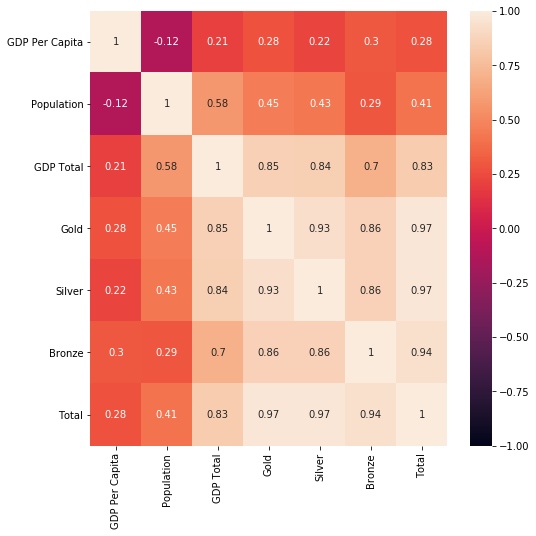

In [27]:
plt.figure(figsize=(8, 8))
sns.heatmap(table.corr(), annot=True, vmin=-1.0, vmax=1.0)
plt.show()

### Verdict

The heatmap determines a strong relationship between the total number of medals and GDP.